In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # cuda 사용시 check 필요1

In [2]:
import tensorflow as tf

2021-11-29 15:38:31.938294: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1


In [3]:
# tf.config.list_physical_devices('GPU')

In [4]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

## Dataset

In [4]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [5]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

In [6]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.

In [7]:
# 데이터 배치를 만들고 섞습니다.
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

2021-11-24 14:24:12.038295: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2021-11-24 14:24:12.065306: E tensorflow/stream_executor/cuda/cuda_driver.cc:314] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-11-24 14:24:12.065333: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: dsserver-MS-7C06
2021-11-24 14:24:12.065338: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: dsserver-MS-7C06
2021-11-24 14:24:12.065421: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 455.23.4
2021-11-24 14:24:12.065439: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 455.23.4
2021-11-24 14:24:12.065443: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 455.23.4
2021-11-24 14:24:12.065988: I tensorflow/core/plat

## Model Structure 구상하기

In [8]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # 주목: 배치사이즈로 None이 주어집니다.
    
    # tf.keras.layers.Conv2DTranspose(filters=out_channels, kernel_size, strides=(1, 1), ...)
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)  # 흑백

    return model

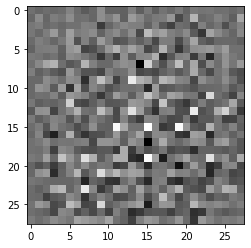

In [9]:
# 아직 훈련되지 않은 생성자의 이미지 생성 결과
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')



In [10]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [11]:
# 아직 훈련되지 않은 판별자의 이미지 생성 결과
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.0029644]], shape=(1, 1), dtype=float32)


## Train 해보기

In [86]:
# 이 메서드는 크로스 엔트로피 손실함수 (cross entropy loss)를 계산하기 위해 헬퍼 (helper) 함수를 반환합니다.
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [87]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [88]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [89]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [90]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [91]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# 이 시드를 시간이 지나도 재활용하겠습니다. 
# (GIF 애니메이션에서 진전 내용을 시각화하는데 쉽기 때문입니다.) 
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [82]:
# `tf.function`이 어떻게 사용되는지 주목해 주세요.
# 이 데코레이터는 함수를 "컴파일"합니다.
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    
    # 한번에 훈련? - 원래는 discriminator 먼저 generator 나중 이렇게 훈련하지 않나?
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [83]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

        # GIF를 위한 이미지를 바로 생성합니다.
        display.clear_output(wait=True)
        generate_and_save_images(generator,
                                 epoch + 1,
                                 seed)

        # 15 에포크가 지날 때마다 모델을 저장합니다.
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        # print (' 에포크 {} 에서 걸린 시간은 {} 초 입니다'.format(epoch +1, time.time()-start))
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    # 마지막 에포크가 끝난 후 생성합니다.
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                               epochs,
                               seed)

In [84]:
# 이미지 생성 및 저장
def generate_and_save_images(model, epoch, test_input):
    # `training`이 False로 맞춰진 것을 주목하세요.
    # 이렇게 하면 (배치정규화를 포함하여) 모든 층들이 추론 모드로 실행됩니다. 
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig('output/image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

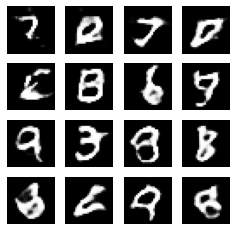

CPU times: user 7h 56min 46s, sys: 7min 32s, total: 8h 4min 19s
Wall time: 45min 5s


In [21]:
%%time
train(train_dataset, EPOCHS)

In [22]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Result 확인하기

In [23]:
# 에포크 숫자를 사용하여 하나의 이미지를 보여줍니다.
def display_image(epoch_no):
    return PIL.Image.open('output/image_at_epoch_{:04d}.png'.format(epoch_no))

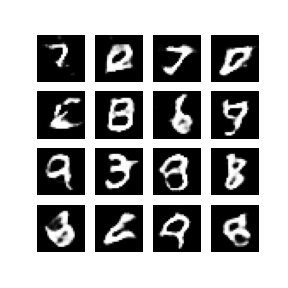

In [24]:
display_image(EPOCHS)

In [26]:
# gif 애니메이션 만들기
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('output/image*.png')
    filenames = sorted(filenames)
    last = -1
    for i,filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)


In [27]:
import IPython
if IPython.version_info > (6,2,0,''):
    display.Image(filename=anim_file)

## pytorch 예제(CelebFACE, structure)를 TF로 만들어보기

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # cuda 사용시 check 필요1

In [2]:
import tensorflow as tf

2021-11-29 16:37:36.334779: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1


In [3]:
# tf.config.list_physical_devices('GPU')

In [4]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

In [5]:
# ====================================================================

In [6]:
### pytorch version으로 만들어보기 - 단, 사람의 얼굴은 불쾌한 골짜기를 잘 넘어야함
# ../../CelebAMask-HQ/CelebA-HQ-img

In [7]:
# Root directory for dataset
data_dir = "../../CelebAMask-HQ/CelebA-HQ-img"

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

In [8]:
# !ls ../../CelebAMask-HQ/CelebA-HQ-img

In [9]:
import os
img_data = os.listdir(data_dir)

In [10]:
len(img_data)

30000

In [11]:
data_dir = [os.path.join(data_dir, path) for path in img_data]

In [12]:
resize_and_rescale = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Resizing(image_size, image_size),
  tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset=-1)  # [-1,1] : tanh
])

2021-11-29 16:37:37.642977: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2021-11-29 16:37:37.685749: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:17:00.0 name: GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.65GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2021-11-29 16:37:37.685773: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2021-11-29 16:37:37.687918: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2021-11-29 16:37:37.689506: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcufft.so.10
2021-11-29 16:37:37.690273: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcurand.so.

In [13]:
def image_load(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = resize_and_rescale(img)
    return img

In [14]:
BUFFER_SIZE = 1000

In [15]:
train_dataset = tf.data.Dataset.from_tensor_slices(data_dir)
train_dataset = train_dataset.map(lambda item1: tf.numpy_function(
          image_load, [item1], [tf.float32]))
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(batch_size).prefetch(BUFFER_SIZE//2)

In [16]:
# for em in train_dataset:
#     break

In [17]:
# em[0].shape

In [18]:
# em[0][0]

In [19]:
# plt.imshow(((em[0][0, :, :, :]  + 1)* 127.5).numpy().astype(np.uint8))

## Model

In [20]:
# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64


In [21]:
# torch 예제와 달리 weight initialization 안했음
def make_generator_model():
    conv_init = tf.keras.initializers.RandomNormal(
        mean=0.0, stddev=0.02, seed=None
    )
#     gamma_initializer= tf.keras.initializers.RandomNormal(
#         mean=1.0, stddev=0.02, seed=None
#     )
    model = tf.keras.Sequential()
    model.add(layers.Dense(4* 4 * ngf * 8, use_bias=False, input_shape=(nz,)))
    model.add(layers.BatchNormalization(epsilon=1e-05))
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((4, 4, ngf * 8)))
    assert model.output_shape == (None, 4, 4, ngf * 8) # 주목: 배치사이즈로 None이 주어집니다.
    
    model.add(layers.Conv2DTranspose(ngf * 8, (4, 4), strides=(1, 1), padding='same',
                                         use_bias=False, kernel_initializer=conv_init))
#     print(model.output_shape)
    assert model.output_shape == (None, 4, 4, ngf * 8)
    model.add(layers.BatchNormalization(epsilon=1e-05))
    model.add(layers.ReLU())
    
    model.add(layers.Conv2DTranspose(ngf * 4, (4, 4), strides=(2, 2), padding='same',
                                         use_bias=False, kernel_initializer=conv_init))
#     print(model.output_shape)
    assert model.output_shape == (None, 8, 8, ngf * 4)
    model.add(layers.BatchNormalization(epsilon=1e-05))
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(ngf * 2, (4, 4), strides=(2, 2), padding='same',
                                         use_bias=False, kernel_initializer=conv_init))
    assert model.output_shape == (None, 16, 16, ngf * 2)
#     print(model.output_shape)
    model.add(layers.BatchNormalization(epsilon=1e-05))
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(ngf, (4, 4), strides=(2, 2), padding='same',
                                         use_bias=False, kernel_initializer=conv_init))
    assert model.output_shape == (None, 32, 32, ngf)
#     print(model.output_shape)
    model.add(layers.BatchNormalization(epsilon=1e-05))
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(nc, (4, 4), strides=(2, 2), padding='same',
                                         use_bias=False, kernel_initializer=conv_init,
                                     activation='tanh'))
    assert model.output_shape == (None, 64, 64, nc)
#     print(model.output_shape)

    return model

2021-11-29 16:37:38.494423: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2021-11-29 16:37:38.651485: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudnn.so.7
2021-11-29 16:37:39.395921: W tensorflow/stream_executor/gpu/asm_compiler.cc:81] Running ptxas --version returned 256
2021-11-29 16:37:39.457865: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


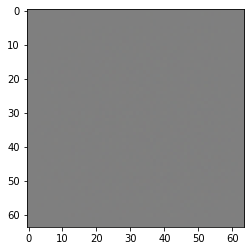

In [22]:
# 아직 훈련되지 않은 생성자의 이미지 생성 결과
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(((generated_image[0, :, :, :]  + 1)* 127.5).numpy().astype(np.uint8))

In [23]:
def make_discriminator_model():
    conv_init = tf.keras.initializers.RandomNormal(
        mean=0.0, stddev=0.02, seed=None
    )
#     gamma_initializer= tf.keras.initializers.RandomNormal(
#         mean=1.0, stddev=0.02, seed=None
#     )
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(ndf, 4, strides=2, use_bias=False,
                                padding='same', kernel_initializer=conv_init,
                                input_shape=[64, 64, nc]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(ndf*2, 4, strides=2, use_bias=False,
                                padding='same', kernel_initializer=conv_init
                           ))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(ndf*4, 4, strides=2, use_bias=False,
                                padding='same', kernel_initializer=conv_init
                           ))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(ndf*8, 4, strides=2, use_bias=False,
                                padding='same', kernel_initializer=conv_init
                           ))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
#     print(model.output_shape)  # None, 4, 4, 512
    
    # 여기를 torch에서는 conv2d로 처리함
    model.add(layers.Conv2D(1, 4, strides=1, use_bias=False,
                             kernel_initializer=conv_init, 
                            activation='sigmoid'
                           ))

    return model

In [24]:
# 아직 훈련되지 않은 판별자의 이미지 생성 결과
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)  # Conv2D >> shape 이상한데 훈련됨...(이상)

tf.Tensor([[[[0.49996895]]]], shape=(1, 1, 1, 1), dtype=float32)


## Train

In [25]:
# 이 메서드는 크로스 엔트로피 손실함수 (cross entropy loss)를 계산하기 위해 헬퍼 (helper) 함수를 반환합니다.
criterion = tf.keras.losses.BinaryCrossentropy() # from_logits=True)

In [26]:
def discriminator_loss(real_output, fake_output):
    real_loss = criterion(tf.ones_like(real_output), real_output)
    fake_loss = criterion(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [27]:
def generator_loss(fake_output):
    return criterion(tf.ones_like(fake_output), fake_output)

In [28]:
lr = 0.0002
beta1 = 0.5

In [29]:
generator_optimizer = tf.keras.optimizers.Adam(lr, beta1)
discriminator_optimizer = tf.keras.optimizers.Adam(lr, beta1)

In [30]:
checkpoint_dir = './training_checkpoints_face'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [31]:
EPOCHS = 100  # gpu 사용해서 더 많이 훈련해야하기는 함
# noise_dim = 100  # = nz
num_examples_to_generate = 8 * 8

# 이 시드를 시간이 지나도 재활용하겠습니다. 
# (GIF 애니메이션에서 진전 내용을 시각화하는데 쉽기 때문입니다.) 
seed = tf.random.normal([num_examples_to_generate, nz])  # test sample

In [32]:
# # `tf.function`이 어떻게 사용되는지 주목해 주세요.
# # 이 데코레이터는 함수를 "컴파일"합니다.
# @tf.function
# def train_step(images):
#     noise = tf.random.normal([batch_size, nz])
    
#     # 한번에 훈련? - 원래는 discriminator 먼저 generator 나중 이렇게 훈련하지 않나?
#     with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
#         generated_images = generator(noise, training=True)

#         real_output = discriminator(images, training=True)
#         fake_output = discriminator(generated_images, training=True)

#         gen_loss = generator_loss(fake_output)
#         disc_loss = discriminator_loss(real_output, fake_output)

#     gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
#     gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

#     generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
#     discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [33]:
# # `tf.function`이 어떻게 사용되는지 주목해 주세요.
# # 이 데코레이터는 함수를 "컴파일"합니다.
# @tf.function
# def train_step(images):
#     noise = tf.random.normal([batch_size, nz])
    
#     # 한번에 훈련 >> discriminator 먼저 generator 나중 이렇게 훈련으로 변경
#     # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
#     with tf.GradientTape() as disc_tape:
#         generated_images = generator(noise, training=False)

#         real_output = discriminator(images, training=True)
#         fake_output = discriminator(generated_images, training=True)
        
#         disc_loss = discriminator_loss(real_output, fake_output)
        
#     gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
#     discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

#     with tf.GradientTape() as gen_tape:
#         # pytorch 에서는 다시 생성하지 않지만 updated discriminator를 사용하려면 어쩔 수 없이 다시 생성함
#         generated_images = generator(noise, training=True)
        
#         fake_output = discriminator(generated_images, training=False)

#         gen_loss = generator_loss(fake_output)

#     gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    
#     generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    
#     return gen_loss, disc_loss

In [34]:
# def discriminator_loss(output, fake=False):
#     if fake == False:
#         total_loss = criterion(tf.ones_like(output), output)  # real_loss
#     else:
#         total_loss = criterion(tf.zeros_like(output), output)  # fake_loss
# #     total_loss = real_loss + fake_loss
#     return total_loss

In [35]:
# `tf.function`이 어떻게 사용되는지 주목해 주세요.
# 이 데코레이터는 함수를 "컴파일"합니다.
@tf.function
def train_step(images):
    noise = tf.random.normal([batch_size, nz])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape_real, tf.GradientTape() as disc_tape_fake:
        generated_images = generator(noise, training=True)
        
        real_output = discriminator(images, training=True)
        disc_loss_real = criterion(tf.ones_like(real_output), real_output)
        
        fake_output = discriminator(generated_images, training=True)
        disc_loss_fake = criterion(tf.zeros_like(fake_output), fake_output)
        
        gen_loss = criterion(tf.ones_like(fake_output), fake_output)
        
    disc_loss = disc_loss_real + disc_loss_fake

    gradients_of_discriminator = disc_tape_real.gradient(disc_loss_real, discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    gradients_of_discriminator = disc_tape_fake.gradient(disc_loss_fake, discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

    return gen_loss, disc_loss

In [36]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        for i, image_batch in enumerate(dataset):
            gen_loss, disc_loss = train_step(image_batch)
            
            # 15 에포크가 지날 때마다 모델을 저장합니다.
            if (i + 1) % (len(dataset)//5) == 0:
                print ('Loss_G {:.4f}, Loss_D {:.4f}, {} sec'.format(gen_loss, disc_loss, time.time()-start))

        # GIF를 위한 이미지를 바로 생성합니다.
        display.clear_output(wait=True)
        generate_and_save_images(generator,
                                 epoch + 1,
                                 seed)

        # 15 에포크가 지날 때마다 모델을 저장합니다.
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        # print (' 에포크 {} 에서 걸린 시간은 {} 초 입니다'.format(epoch +1, time.time()-start))
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    # 마지막 에포크가 끝난 후 생성합니다.
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                               epochs,
                               seed)

In [37]:
# 이미지 생성 및 저장
def generate_and_save_images(model, epoch, test_input):
    # `training`이 False로 맞춰진 것을 주목하세요.
    # 이렇게 하면 (배치정규화를 포함하여) 모든 층들이 추론 모드로 실행됩니다. 
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(8,8))

    for i in range(predictions.shape[0]):
        plt.subplot(8, 8, i+1)
        plt.imshow(((predictions[i, :, :, :]  + 1)* 127.5).numpy().astype(np.uint8))
        plt.axis('off')

    plt.savefig('output/face_image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

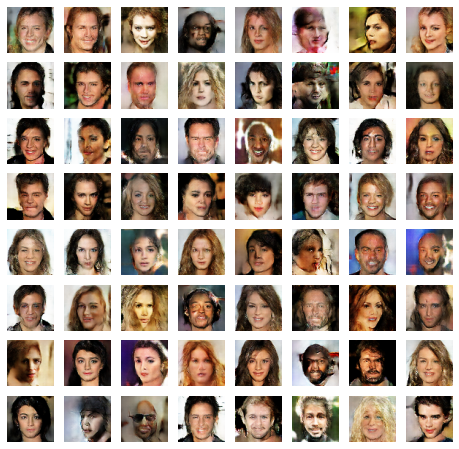

CPU times: user 4h 24min 23s, sys: 10min 43s, total: 4h 35min 7s
Wall time: 5h 20s


In [38]:
%%time
train(train_dataset, EPOCHS)

In [39]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [44]:
generator.save("face_generator")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


2021-11-29 21:38:07.964669: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: face_generator/assets


In [45]:
discriminator.save("face_discriminator")

INFO:tensorflow:Assets written to: face_discriminator/assets


In [46]:
generator.save_weights("face_generator_weights.h5")

In [47]:
discriminator.save_weights("face_discriminator_weights.h5")

## Result 확인하기

In [ ]:
## [사진보다 그림같은 느낌임]
## collapse mode 현상 일어남 >> 점점 다양한 이목구비, 표정, 각도 >> 선그라스, 안경 >> 머리카락, 얼굴형

In [40]:
# 에포크 숫자를 사용하여 하나의 이미지를 보여줍니다.
def display_image(epoch_no):
    return PIL.Image.open('output/face_image_at_epoch_{:04d}.png'.format(epoch_no))

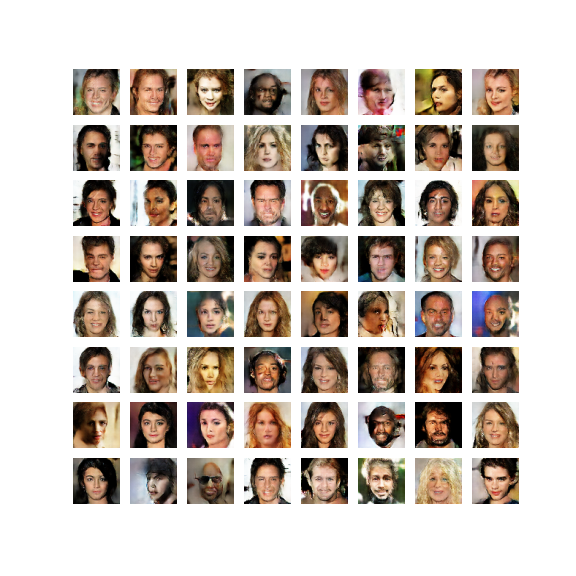

In [41]:
display_image(EPOCHS)

In [48]:
# gif 애니메이션 만들기
anim_file = 'face_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('output/face_image*.png')
    filenames = sorted(filenames)
    last = -1
    for i,filename in enumerate(filenames):
        frame = 2*i
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)


In [49]:
import IPython
if IPython.version_info > (6,2,0,''):
    display.Image(filename=anim_file)